In [1]:
import torch
import yaml
import os
import sys
sys.path.append('/home/yang_liu/python_workspace/3DGS')

import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tf
from PIL import Image
from tqdm import tqdm
from os import makedirs
from scene import Scene
from gaussian_renderer import render
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams
from utils.loss_utils import l1_loss, ssim

In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def readImages(renders_dir, gt_dir):
    renders = []
    gts = []
    image_names = []
    for fname in os.listdir(renders_dir):
        render = Image.open(renders_dir / fname)
        gt = Image.open(gt_dir / fname)
        renders.append(tf.to_tensor(render).unsqueeze(0)[:, :3, :, :].cuda())
        gts.append(tf.to_tensor(gt).unsqueeze(0)[:, :3, :, :].cuda())
        image_names.append(fname)
    return renders, gts, image_names

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

In [3]:
config = '../config/block_mc_aerial_block_all_lr_c25_loss_8_num_10w_lr2.yaml'
out_dir = '../output/block_mc_aerial_block_all_lr_c25_loss_8_num_10w_lr2'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)

config_name = os.path.splitext(os.path.basename(config))[0]
lp.source_path = os.path.join("../", lp.source_path)
lp.model_path = os.path.join("../output/", config_name)

## 1. Merge Gaussian Cells

In [ ]:
merged_gaussians = GaussianModel(lp.sh_degree)
num_blocks = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
with torch.no_grad():
    for idx in range(num_blocks):
        gaussians = GaussianModel(lp.sh_degree)
        try:
            gaussians.load_ply(os.path.join(out_dir, f"cells/cell{idx}", "point_cloud_blocks", "scale_1.0",
                                            "iteration_" + str(iteration),
                                            "point_cloud.ply"))
        except:
            gaussians.load_ply(os.path.join(out_dir, f"cells/cell{idx}", "point_cloud_blocks", "scale_1.0",
                                            "iteration_" + str(1),
                                            "point_cloud.ply"))
        
        # plt.figure()
        # plt.style.use('seaborn-white')
        # plt.scatter(gaussians.get_xyz[::100, 0].detach().cpu(), gaussians.get_xyz[::100, 1].detach().cpu(), s=0.5, c='r', label=f'cell-{idx}')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        
        if len(merged_gaussians._xyz) == 0:
            merged_gaussians._xyz = gaussians.get_xyz
            merged_gaussians._features_dc = gaussians._features_dc
            merged_gaussians._features_rest = gaussians._features_rest
            merged_gaussians._scaling = gaussians._scaling
            merged_gaussians._rotation = gaussians._rotation
            merged_gaussians._opacity = gaussians._opacity
            merged_gaussians.max_radii2D = gaussians.max_radii2D
        else:
            merged_gaussians._xyz = torch.cat([merged_gaussians._xyz, gaussians.get_xyz], dim=0)
            merged_gaussians._features_dc = torch.cat([merged_gaussians._features_dc, gaussians._features_dc], dim=0)
            merged_gaussians._features_rest = torch.cat([merged_gaussians._features_rest, gaussians._features_rest], dim=0)
            merged_gaussians._scaling = torch.cat([merged_gaussians._scaling, gaussians._scaling], dim=0)
            merged_gaussians._rotation = torch.cat([merged_gaussians._rotation, gaussians._rotation], dim=0)
            merged_gaussians._opacity = torch.cat([merged_gaussians._opacity, gaussians._opacity], dim=0)
            merged_gaussians.max_radii2D = torch.cat([merged_gaussians.max_radii2D, gaussians.max_radii2D], dim=0)
        
        print(f"Merged {len(gaussians.get_xyz)} points from block {idx}")

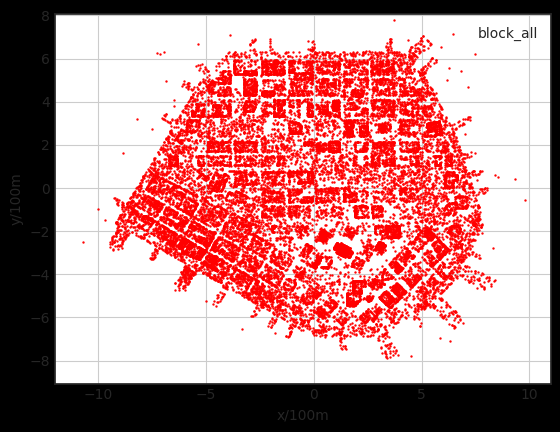

In [5]:
plt.figure()
plt.style.use('seaborn-white')
plt.scatter(merged_gaussians.get_xyz[::1000, 0].detach().cpu(), merged_gaussians.get_xyz[::1000, 1].detach().cpu(), s=0.5, c='r', label='block_all')
plt.axis('equal')
plt.xlim(-12, 11)
plt.xlabel('x/100m')
plt.ylabel('y/100m')
plt.ylim(-8, 7)
plt.legend()
plt.grid(True)
plt.show()

In [6]:
save_path = os.path.join(out_dir, "point_cloud", "iteration_" + str(iteration), "point_cloud.ply")
print(f"Saving merged {len(merged_gaussians.get_xyz)} point cloud to {save_path}")
merged_gaussians.save_ply(save_path)
print('Done')

Saving merged 25399883 point cloud to ../output/block_mc_aerial_block_all_lr_c25_loss_8_num_10w_lr2/point_cloud/iteration_30000/point_cloud.ply
Done


## 2. Load GS and find bad case

In [ ]:
gaussians = GaussianModel(lp.sh_degree)
gaussians.load_ply(os.path.join(out_dir, "point_cloud",
                                "iteration_" + str(30000),
                                "point_cloud.ply"))
print(f"Loaded {len(gaussians.get_xyz)} points from point cloud")

In [246]:
from utils.loss_utils import ssim
from lpipsPyTorch import lpips
from utils.image_utils import psnr
from pathlib import Path

ssims = []
psnrs = []
# lpipss = []
method_dir = Path("../output/org_mc_aerial_block9/block_9_test/ours_30000")
gt_dir = method_dir / "gt"
renders_dir = method_dir / "renders"
renders, gts, image_names = readImages(renders_dir, gt_dir)
for idx in tqdm(range(len(renders)), desc="Metric evaluation progress"):
    ssims.append(ssim(renders[idx], gts[idx]))
    psnrs.append(psnr(renders[idx], gts[idx]))
    # lpipss.append(lpips(renders[idx], gts[idx], net_type='vgg'))

Metric evaluation progress: 100%|██████████| 247/247 [00:01<00:00, 231.45it/s]


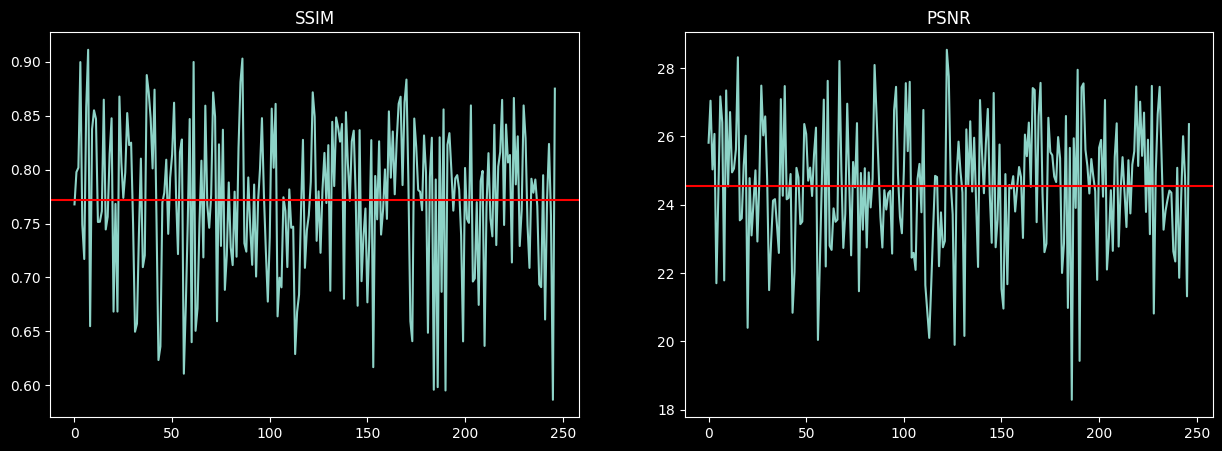

In [247]:
# plot distribution of each metric
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
ssims_list = [x.cpu().numpy().squeeze() for x in ssims]
ssim_mean = np.mean(ssims_list)
plt.plot(ssims_list)
plt.axhline(y=ssim_mean, color='r', linestyle='-')
plt.title("SSIM")

plt.subplot(1, 2, 2)
psnrs_list = [x.cpu().numpy().squeeze() for x in psnrs]
psnr_mean = np.mean(psnrs_list)
plt.plot(psnrs_list)
plt.axhline(y=psnr_mean, color='r', linestyle='-')
plt.title("PSNR")

# plt.subplot(1, 3, 3)
# lpipss_list = [x.cpu().numpy().squeeze() for x in lpipss]
# lpipss_mean = np.mean(lpipss_list)
# plt.plot(lpipss_list)
# plt.axhline(y=lpipss_mean, color='r', linestyle='-')
# plt.title("LPIPS")

plt.show()

In [243]:
target_idx = 0
metric = "PSNR"

In [338]:
current_idx = 0
for idx in range(len(renders)):
    if metric == "SSIM":
        metric_value = ssims_list[idx]
        thershold = 0.75
    elif metric == "PSNR":
        metric_value = psnrs_list[idx]
        thershold = 24
    # elif metric == "LPIPSS":
    #     metric_value = -lpipss_list[idx]
    #     thershold = -0.35
    
    if metric_value < thershold:  # 0.75 for ssim, 25 for psnr
        if target_idx == current_idx:
            plt.figure(figsize=(16, 8))
            plt.subplot(1, 2, 1)
            plt.imshow(renders[idx].squeeze().cpu().numpy().transpose(1, 2, 0))
            plt.title(f"Render-{idx}-{metric}-{metric_value}")
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.imshow(gts[idx].squeeze().cpu().numpy().transpose(1, 2, 0))
            plt.title(f"GT-{idx}-{metric}-{metric_value}")
            plt.axis("off")
            plt.show()
            break
        else:
            current_idx += 1
target_idx += 1